In [1]:
%%capture
!python3 -m pip install pandas numpy matplotlib tensorflow tqdm bs4 IP2Location

In [2]:
import requests
import urllib3
from urllib.parse import urlparse, urljoin
import socket

from bs4 import BeautifulSoup
import chardet
import re
import json
import ast

import math
import statistics
from matplotlib import pyplot

import os
import IP2Location

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras import Sequential
import tensorflow.keras.layers
import tensorflow.keras.losses

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import warnings
warnings.filterwarnings(action="ignore", module="urllib3")

In [3]:
DOWNLOAD_CHUNK_SIZE = 10
TIMEOUT = (10, 10)
feature_names = ["words", "aux", "city", "region", "country", "redirects", "latitude", "longitude"]

In [4]:
ip2location_database = IP2Location.IP2Location()
ip2location_database.open(os.path.join("location_data", "IP2LOCATION-LITE-DB11.BIN"))
def get_location(ip_addr=None, hostname=None):
    if(ip_addr is None and hostname is not None):
        try:
            ip_addr = socket.gethostbyname(hostname)
        except socket.gaierror:
            print("Skipped Location Download (Hostname Resolution Error for '"+hostname+"')")
            return None
    location_data = ip2location_database.get_all(ip_addr)
    if(location_data.country_short == "-"):
        if(not ip_addr in location_database):
            location_data = requests.get("https://ipinfo.io/"+ip_addr+"/json").json()
            if("error" in location_data):
                raise Exception("Failed because error with download (probably api quota exceded)")
            location_database[ip_addr] = location_data
            location_database[ip_addr]["country_short"] = location_data["country"]
            location_database[ip_addr]["latitude"], location_database[ip_addr]["longitude"] = tuple(location_data["loc"].split(","))
    else:
        return ast.literal_eval(str(location_data))
    return location_database[ip_addr]

In [5]:
def get_absolute_url_from_relative(original_url, new_url):
    if(new_url.startswith("javascript")):
        return None
    if(new_url.startswith("http")):
        return new_url
    url_with_scheme = "http://"+original_url if not original_url.startswith("http") else original_url
    parsed_url = urlparse(url_with_scheme)
    url_scheme = parsed_url.scheme
    url_host = parsed_url.netloc
    
    return urljoin(url_scheme+"://"+url_host, new_url)

In [6]:
def download_aux_data(content, original_url):
    aux = []
    soup = BeautifulSoup(content, 'html.parser')
    for a in soup.find_all('a'):
        href = a.get('href')
        if(href is not None):
            url = get_absolute_url_from_relative(original_url, href)
            if(url is not None):
                hostname = urlparse(url).netloc
                json = get_location(hostname=hostname)
                if(json is None):
                    continue
                try:
                    columns = [
                        "hostname_"+hostname,
                        "ip_addr_"+json["ip"],
                        "latitude_"+str(int(float(json["latitude"]))),
                        "longitude_"+str(int(float(json["longitude"]))),
                        "city_"+json["city"],
                        "region_"+json["region"],
                        "country_"+json["country_short"],
                    ]
                except KeyError:
                    if("bogon" in json and json["bogon"]):
                        print("Skipped Aux Data Download (Bogon IP)")
                    else:
                        print("Problem with JSON: ", json)
                    columns = []
                
                columns = [ re.compile('[\W_]+').sub('_', column) for column in columns ]
                
                aux = aux + columns
                
    return " ".join(aux)

In [7]:
def download_one(original_url, timeout=TIMEOUT):
    row = {}
    row["attempted_download"] = True

    url_with_scheme = "http://"+original_url if not original_url.startswith("http") else original_url
    parsed_url = urlparse(url_with_scheme)
    hostname = parsed_url.netloc
    
    try:
        row["hostname"] = hostname
        
        ip_addr = socket.gethostbyname(hostname)
        row["ip_addr"] = ip_addr

        r = requests.get(url_with_scheme, verify=False, timeout=timeout)

        row["status_code"] = r.status_code
        encoding = chardet.detect(r.content)['encoding']
        #if(encoding == None):
        #    print("Skipped content download (Decoding Error)")
        try:
            content = r.content.decode(encoding)
            row["content"] = content
        except:
            try:
                content = r.content.decode("utf")
            except:
                content = None
                print("Skipped Content Download (Decoding Error)")
            
        if(content is not None):
            row["aux"] = download_aux_data(content, original_url)
            row["words"] = " ".join(re.compile('[\W_]+').sub(' ', BeautifulSoup(content, 'html.parser').get_text()).split(" "))
        
        redirects = 0
        for r_history in r.history:
            if(r_history.status_code == 301):
                redirects = redirects + 1
        row["redirects"] = redirects

        json = get_location(ip_addr=ip_addr)
        if(json is None):
            return row
        try:
            row["latitude"] = json["latitude"]
            row["longitude"] = json["longitude"]
            row["city"] = json["city"]
            row["region"] = json["region"]
            row["country"] = json["country_short"]

        except KeyError:
            if("bogon" in json and json["bogon"]):
                print("Skipped Location Download (Bogon IP)")
            else:
                print("Problem with JSON: ", json)
        
    except socket.gaierror:
        print("Skipped (Hostname Resolution Error for '"+hostname+"')")
                      
    except socket.error:
        print("Skipped (Content Download Error for '"+original_url+"')")
        
    except UnicodeError:
        print("Skipped (Unicode Error for '"+original_url+"')")
    
    return row

In [8]:
def download_chunk(chunk_size=DOWNLOAD_CHUNK_SIZE, timeout=TIMEOUT):
    global raw_data
    if(len(raw_data[raw_data["attempted_download"] == True].index) != 0):
          start = raw_data[raw_data["attempted_download"] == True].index[-1]+1
    end = start + chunk_size
    end = end if len(raw_data["url"]) > end else len(raw_data["url"])
    
    print("Downloading %d more rows ([%d:%d])" % (chunk_size, start, end))
    for row_index in tqdm(range(start, end)):
        row = download_one(raw_data.loc[row_index, "url"], timeout=timeout)
        if(len(list(row)) > 0):
            raw_data.loc[row_index, list(row)] = row.values()

In [9]:
def load_data():
    global raw_data, location_database
    
    raw_data = pd.read_csv("./raw_data.csv")
    raw_data["attempted_download"] = False
    
    try:
        with open("./location_data.json", 'r') as file:
            location_database = json.load(file)
        file.close()
    except FileNotFoundError:
        location_database = {}

    try:
        raw_data = pd.read_csv("./data.csv", index_col=0, low_memory=False)
        if(DOWNLOAD_CHUNK_SIZE > 0):
            download_chunk()
            raw_data.to_csv("./data.csv")
            with open("./location_data.json", 'w') as file:
                json.dump(location_database, file)
            file.close()

    except FileNotFoundError:
        download_chunk()
        raw_data.to_csv("./data.csv")
        with open("./location_data.json", 'w') as file:
            json.dump(location_database, file)
        file.close()

    data = raw_data.copy()

    data = data.drop("attempted_download", axis=1)
    data = data[data["status_code"] == 200]
    data = data.drop("status_code", axis=1)
    data = data[feature_names + ["type", "url"]].dropna()
    data = data.reset_index(drop=True)
    data["redirects"] = data["redirects"].astype(np.str)
    data["latitude"] = data["latitude"].astype(np.str)
    data["longitude"] = data["longitude"].astype(np.str)
    return data

In [10]:
data = load_data()
data

  0%|          | 0/10 [00:00<?, ?it/s]

Skipped (Hostname Resolution Error for 'banking.bmo-securevalidation.com')
Skipped (Hostname Resolution Error for 'jimcu.edu.m1dcountry.com')
Skipped (Hostname Resolution Error for 'elisstars.esy.es')
Skipped (Hostname Resolution Error for 'littlebigjosh.com')
Skipped (Hostname Resolution Error for 'bodikianjewellery.com.au')


,words,aux,city,region,country,redirects,latitude,longitude,type,url
0,larcadelcarnevale com Buy this domain larcade...,hostname_secure_voodoo_com ip_addr_192_64_146_...,Munich,Bavaria,DE,0.0,48.1374,11.5755,defacement,http://larcadelcarnevale.com/catalogo/palloncini
1,Sorteo Notebook Diciembre 2012JavaScript isn t...,hostname_accounts_google_com ip_addr_142_251_1...,Washington,"Washington, D.C.",US,2.0,38.8951,-77.0364,phishing,https://docs.google.com/spreadsheet/viewform?f...
2,Shopper s Heaven 인터파크 홈 리빙 세탁 청소용품 리빙 최신 등록순 ...,hostname_interpark_com ip_addr_211_233_74_23 l...,Seoul,Seoul,KR,0.0,37.566,126.9784,benign,http://interpark.com/displaycorner/FreeMarket....
3,Links KontaktAnfahrtDatenschutzImpressum Home...,hostname_www_pn_wuppertal_de ip_addr_217_160_0...,Karlsruhe,Baden-Wurttemberg,DE,1.0,49.0094,8.4044,defacement,http://www.pn-wuppertal.de/links/2-linkseite/5...
4,AfterMarket pl domena parafiapiaski pl Domena...,hostname_www_aftermarket_pl ip_addr_185_253_21...,Warsaw,Mazovia,PL,0.0,52.2298,21.0118,defacement,http://www.parafiapiaski.pl/index.php?option=c...
...,...,...,...,...,...,...,...,...,...,...
738,State Bar of Texas Home TexasBar com Home Sta...,hostname_texasbar_com ip_addr_204_65_203_165 l...,Austin,Texas,US,1.0,30.278219,-97.737602,benign,texasbar.com/
739,Michael Scott Speicher OurWarHeroes org Tribu...,hostname_www_freescottspeicher_org ip_addr_104...,Ann Arbor,Michigan,US,0.0,42.228848,-83.735924,benign,iraqwarheroes.org/speicher.htm
740,linda historia de amor YouTubeAboutPressCopyri...,hostname_youtube_com ip_addr_142_251_163_136 l...,Mountain View,California,US,2.0,37.405991,-122.078514,benign,youtube.com/watch?v=bv_sdHTZbt0
741,Crown City Rockers Earthtones Lyrics Lyrics M...,hostname_lyricsmania_com ip_addr_213_227_139_3...,Amsterdam,Noord-Holland,NL,1.0,52.378502,4.899980,benign,lyricsmania.com/earthtones_lyrics_crown_city_r...


In [11]:
max_features = 10000
sequence_length = 1000
epochs = 25
folds = 5
batch_size = 1
test_size = 0.33


sl = tf.keras.layers.StringLookup(output_mode='one_hot')
sl.adapt(data["type"])
y = sl(list(data["type"]))


X_train, X_test, y_train, y_test = train_test_split(data[feature_names], y, test_size=test_size)

METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      #tf.keras.metrics.Precision(name='precision'),
      #tf.keras.metrics.Recall(name='recall'),
      #tf.keras.metrics.AUC(name='auc'),
      #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def custom_standardization(input_data):
    return tf.strings.lower(input_data)

def get_normalization_layer(feature_name):
    normalization_layer = tf.keras.layers.Normalization(axis=None)
    normalization_layer.adapt(data[feature_name].astype(np.float32))
    return normalization_layer

def get_vectorize_layer(feature_name):
    vectorize_layer = tf.keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode='int',
        output_sequence_length=sequence_length
    )
    vectorize_layer.adapt(data[feature_name])
    return vectorize_layer

def get_string_lookup(feature_name):
    lookup = tf.keras.layers.StringLookup(
        output_mode='one_hot',
        max_tokens=sequence_length,
        pad_to_max_tokens=True,
    )
    lookup.adapt(data[feature_name])
    return lookup

inputs = tf.keras.Input(shape=(len(feature_names),), dtype=tf.string)
outputs = []
for i in range(len(feature_names)):
    feature_name = feature_names[i]
    flatten = tf.keras.layers.Flatten()
    if(feature_name == "latitude" or feature_name == "longitude"):
        outputs.append(flatten(get_normalization_layer(feature_name)(tf.strings.to_number(inputs[:,i], out_type=tf.dtypes.float32))))
    else:
        embedding_layer = tf.keras.layers.Embedding(max_features, 5)
        if(feature_name == "words" or feature_name == "aux"):
            layer = get_vectorize_layer(feature_name)
        else:
            layer = get_string_lookup(feature_name)
        outputs.append(tf.keras.layers.Flatten()(embedding_layer(layer(flatten(inputs[:,i])))))
    
    
outputs = tf.concat(outputs, axis=-1)

sequential_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(5)
])


model = tf.keras.Model(inputs=inputs, outputs=sequential_model(outputs) )


model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=METRICS
)

model.summary()
sequential_model.summary()

kfold = KFold(n_splits=folds, shuffle=True)

histories = []
for train, validation in kfold.split(X_train, y_train):
    
    y_classes = np.argmax(y_train[train].numpy(), axis=1)
    y_labels = np.unique(y_classes)
    class_weights = compute_class_weight(class_weight='balanced', classes=y_labels, y=y_classes)
    class_weights = dict(zip(y_labels, class_weights))
    class_weights[0] = 0
    
    history = model.fit(
        X_train.iloc[train],
        y_train[train],
        validation_data=(X_train.iloc[validation], y_train[validation]),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
        class_weight=class_weights
    )
    histories.append(history)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None,)              0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None,)              0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None,)              0           input_1[0][0]                    
______________________________________________________________________________________________

In [12]:
model.evaluate(X_test, y_test, batch_size=batch_size)

246/246 [==============================] - 1s 2ms/step - loss: 0.3741 - accuracy: 0.9537


[0.3741445541381836, 0.9536588788032532]

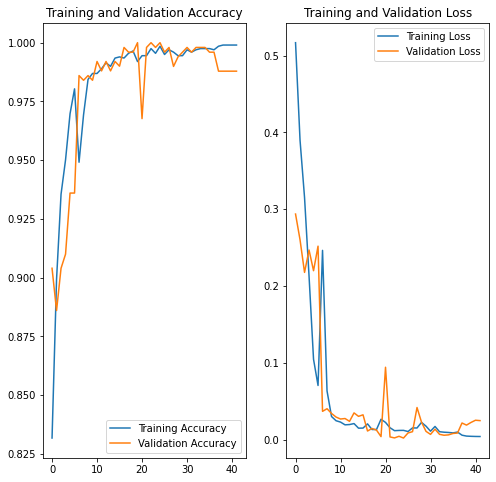

In [13]:
acc = []
val_acc = []
loss = []
val_loss = []
for history in histories:
    acc = acc + history.history['accuracy']
    val_acc = val_acc + history.history['val_accuracy']

    loss = loss + history.history['loss']
    val_loss = val_loss + history.history['val_loss']
    

epochs_range = range(len(acc))

pyplot.figure(figsize=(8, 8))
pyplot.subplot(1, 2, 1)
pyplot.plot(epochs_range, acc, label='Training Accuracy')
pyplot.plot(epochs_range, val_acc, label='Validation Accuracy')
pyplot.legend(loc='lower right')
pyplot.title('Training and Validation Accuracy')

pyplot.subplot(1, 2, 2)
pyplot.plot(epochs_range, loss, label='Training Loss')
pyplot.plot(epochs_range, val_loss, label='Validation Loss')
pyplot.legend(loc='upper right')
pyplot.title('Training and Validation Loss')
pyplot.show()

In [14]:
def to_type(one_hot_encoding):
    return sl.get_vocabulary()[np.argmax(tf.nn.softmax(one_hot_encoding))]

urls = [ data.loc[i, "url"] for i in range(len(X_test)) ]
predictions = [ to_type(model.predict(X_test)[i]) for i in range(len(X_test)) ]
actuals = [ to_type(y_test[i]) for i in range(len(y_test)) ]

df = pd.DataFrame(np.array([urls, actuals, predictions]).T, columns=["url", "actual", "predicted"])
df.reset_index(drop=True)
df[df["actual"] != df["predicted"]]

,url,actual,predicted
4,http://www.parafiapiaski.pl/index.php?option=c...,benign,malware
5,http://fanpage.gr/family/gineka/%ce%b1%cf%85%c...,defacement,benign
10,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,defacement,benign
12,http://mic.com/articles/117758/mtv-just-gave-t...,malware,phishing
20,http://www.sandroecicero.com.br/index.php?opti...,benign,defacement
29,http://rendeck.com/index.php/en/services/consu...,defacement,phishing
40,http://jcmt.nl/en/sitemap,defacement,phishing
41,http://www.food-nrw.de/index.php/forum/257-for...,benign,phishing
44,http://www.enventureonline.com/services/enterp...,malware,defacement
50,http://haberler.com/galatasaray-mersin-idman-y...,defacement,benign


In [15]:
def predict(url):
    one = download_one(url)
    if(one is None or one["status_code"] != 200):
        return "Failed to get data for '" + url + "'"
    one = pd.DataFrame([one.values()], columns=list(one))
    one["redirects"] = one["redirects"].astype(str)
    one["latitude"] = one["latitude"].astype(str)
    one["longitude"] = one["longitude"].astype(str)
    return to_type(model.predict(one[feature_names]))

In [16]:
print(predict("https://cnn.com/"))
print(predict("https://google.com/"))
print(predict("https://disneyplus.com/"))
print(predict("https://uvm.edu/"))
print(predict("https://en.wikipedia.org/"))

benign
benign
benign
benign
benign
